In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence

In [2]:
# =============================== PREVIOUS CODE ===============================
vocab = "$" + ''.join(chr(ord('a') + i) for i in range(26))
vocab_size = len(vocab)
# Create dictionaries for character to index and index to character
ch_to_i = {char: i for i, char in enumerate(vocab)}
i_to_ch = {i: char for i, char in enumerate(vocab)}

# Define encode and decode functions
encode = lambda word: torch.tensor([ch_to_i[c] for c in word])
decode = lambda tensor_i: ''.join(i_to_ch[i.item()] for i in tensor_i)

# Get data
names = []
with open('../data/p2ch9/names_2022.txt', 'r') as file:
    for line in file:
        name, _, _= line.lower().strip().split(',')
        names.append(name)

# filter out names 10 characters and longer
names = [name for name in names if len(name) < 10]
# Add special character boundary to names
names = ['$' + name + '$' for name in names]

# Length of max name
max_name_length = max(len(name) for name in names)
longest_name = max(names, key=len)
longest_name_index = names.index(longest_name)

# Create a function to get a batch of data
names_index = [torch.tensor([ch_to_i[char] for char in name]) for name in names]
targets_index = [name_index[1:] for name_index in names_index]
names_index[0], targets_index[0]

from torch.nn.utils.rnn import pad_sequence
X = pad_sequence(names_index, batch_first=True, padding_value=0)
# trick to pad Y with with -1 and the same size as X
targets_index.append(X[0])
Y = pad_sequence(targets_index, batch_first=True, padding_value=-1)[:-1]

def get_batch(batch_size=64):
    random_idx = torch.randint(0, X.size(0), (batch_size,))
    batch = X[random_idx]
    labels = Y[random_idx]
    return batch, labels
batch, labels = get_batch()

def train(model, optimizer, num_steps=10_001, loss_report_interval=1_000):
    losses = []
    for i in range(1, num_steps):
        inputs, labels = get_batch()
        optimizer.zero_grad()
        logits = model(inputs)
        loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), labels.view(-1), ignore_index=-1)
        losses.append(loss.item())
        if i % loss_report_interval == 0:
            print(f'Average loss at step {i}: {sum(losses[-loss_report_interval:]) / loss_report_interval:.4f}')
        loss.backward()
        optimizer.step()

def generate_samples(model, num_samples=1, max_len=max_name_length):
    sequences = torch.zeros((num_samples, 1)).int()
    for _ in range(max_len):
        logits = model(sequences)
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        sequences = torch.cat((sequences, idx_next), dim=1)

    for sequence in sequences:
        indices = torch.where(sequence == 0)[0]
        end = indices[1] if len(indices) > 1 else max_len
        sequence = sequence[1:end]
        print(decode(sequence))
# =============================== FINISH PREVIOUS CODE ===============================

In [3]:
class SequenceMLP(nn.Module):
    def __init__(self, vocab_size, max_sequence_length, embedding_dim, hidden_dim=32):
        super().__init__()
        self.vocab_size = vocab_size
        self.max_sequence_length = max_sequence_length
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim * max_sequence_length, hidden_dim)
        self.relu = nn.ReLU()
        self.out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        batch_size, seq_len = x.shape
        sequence_embeddings = torch.zeros(batch_size, seq_len, self.max_sequence_length * self.embedding_dim)
        for i in range(seq_len):  # <1>
            subsequence = torch.zeros(batch_size, self.max_sequence_length, dtype=torch.int)
            prefix = x[:, :i+1]
            subsequence[:, :i+1] = prefix
            emb = self.embedding(subsequence)
            sequence_embeddings[:, i, :] = emb.view(batch_size, -1)  # <2>
        x = self.linear(sequence_embeddings)  # <3>
        x = self.relu(x)
        x = self.out(x)
        return x

embedding_dim = 3
max_sequence_length = X.shape[1]
model = SequenceMLP(vocab_size, max_sequence_length, embedding_dim)

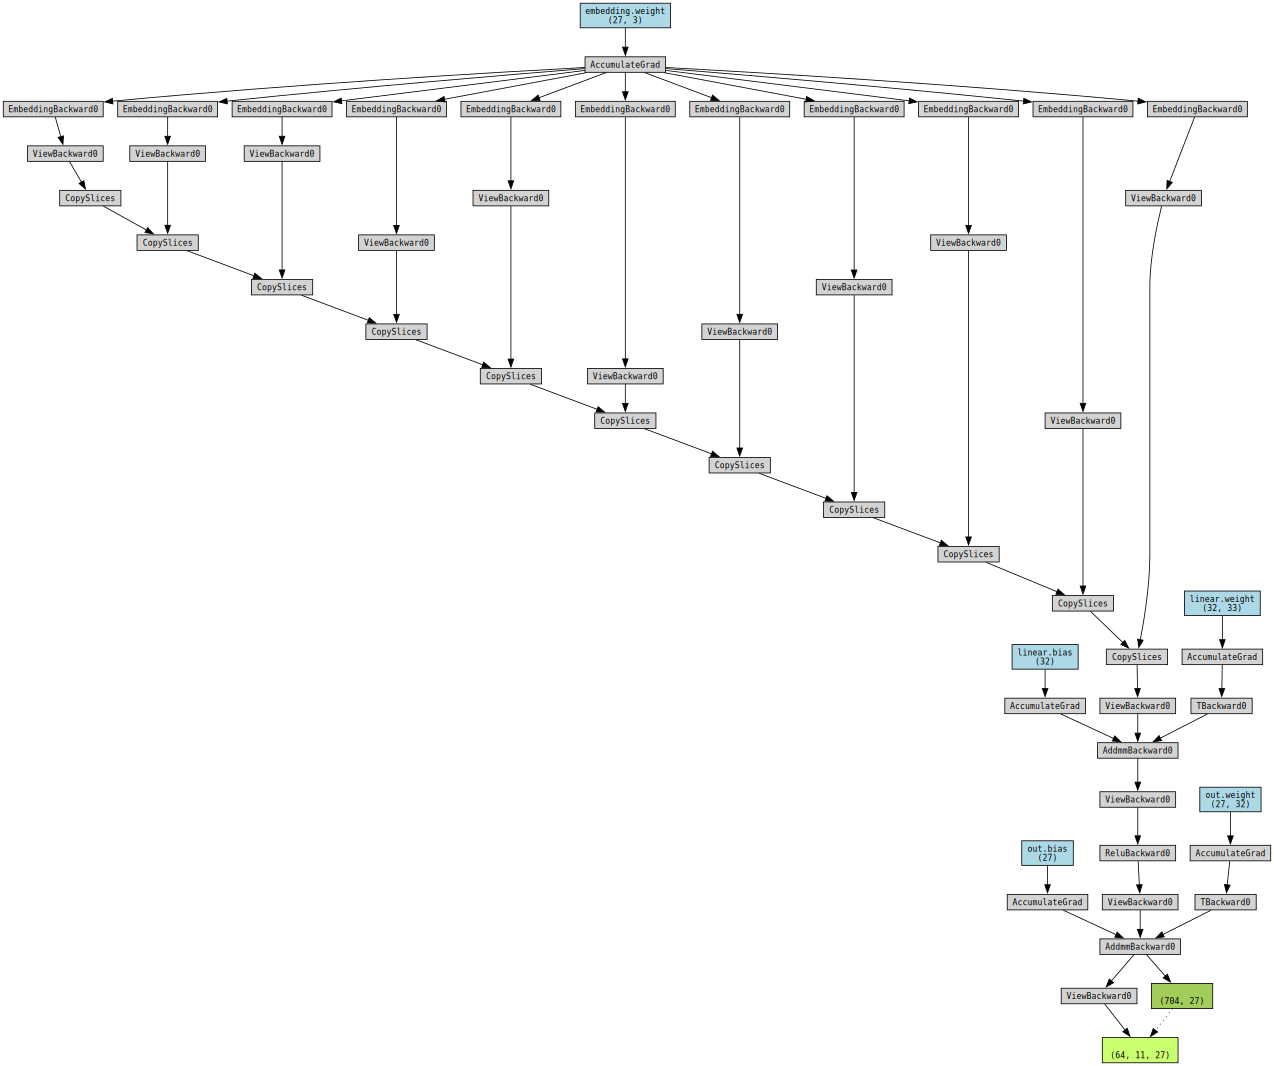

In [4]:
from torchviz import make_dot
make_dot(model(batch), params=dict(model.named_parameters()))

In [5]:
from torchinfo import summary

summary(model, input_data=batch)

Layer (type:depth-idx)                   Output Shape              Param #
SequenceMLP                              [64, 11, 27]              --
├─Embedding: 1-1                         [64, 11, 3]               81
├─Embedding: 1-2                         [64, 11, 3]               (recursive)
├─Embedding: 1-3                         [64, 11, 3]               (recursive)
├─Embedding: 1-4                         [64, 11, 3]               (recursive)
├─Embedding: 1-5                         [64, 11, 3]               (recursive)
├─Embedding: 1-6                         [64, 11, 3]               (recursive)
├─Embedding: 1-7                         [64, 11, 3]               (recursive)
├─Embedding: 1-8                         [64, 11, 3]               (recursive)
├─Embedding: 1-9                         [64, 11, 3]               (recursive)
├─Embedding: 1-10                        [64, 11, 3]               (recursive)
├─Embedding: 1-11                        [64, 11, 3]               (recurs